In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive',force_remount=True)

In [ ]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
!pip3 install imgaug


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
from imgaug import augmenters as iaa

import pandas as pd
import ntpath
import random

In [ ]:
#datadir='/content/gdrive/MyDrive/self_driving_car'
datadir='track'
columns=['center','left','right','steering','throttle','reverse','speed']
data=pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',-1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


center  ...     speed
0  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

In [ ]:
def path_leaf(path):
  head,tail=ntpath.split(path)
  return tail
data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()


center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

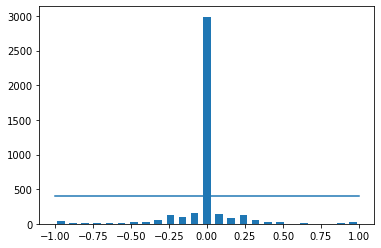

In [ ]:
num_bins=25
samples_per_bin=400
hist,bins=np.histogram(data['steering'],num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))


In [ ]:
#balancing data
print('total_data',len(data))
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range(len(data['steering'])):
    if data['steering'][i]>=bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed=',len(remove_list))

total_data 4053
removed= 2590


In [ ]:
data.drop(data.index[remove_list],inplace=True)
print('remaining',len(data))

remaining 1463


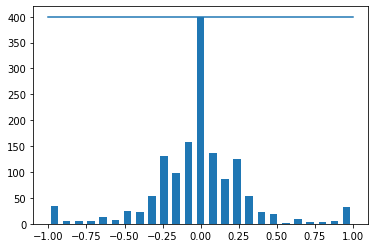

In [ ]:
hist,_=np.histogram(data['steering'],(num_bins))
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
def load_img_steering(datadir,df):
  image_path=[]
  steering=[]
  for i in range(len(data)):
    indexed_data=data.iloc[i]
    center,left,right=indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings
image_paths,steerings=load_img_steering(datadir+'/IMG',data)

In [ ]:
X_train,X_valid,y_train,y_valid=train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print(f'Training Samples :{len(X_train)}\nValid Samples:{len(X_valid)}')




Training Samples :1170
Valid Samples:293


Text(0.5, 1.0, 'validating_set')

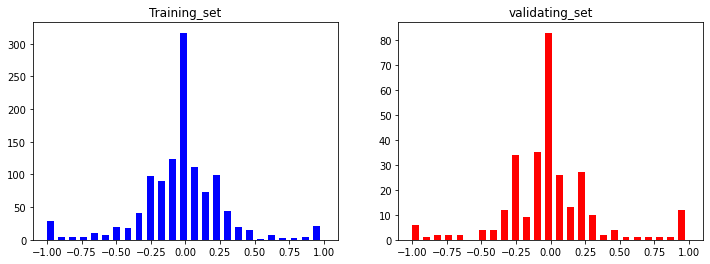

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training_set')
axes[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axes[1].set_title('validating_set')


In [ ]:
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3))
  image=zoom.augment_image(image)
  return image


Text(0.5, 1.0, 'zoom')

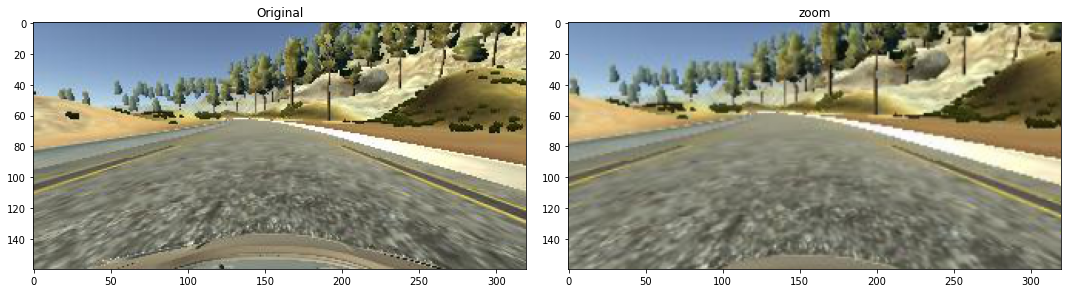

In [ ]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
zoomed_image=zoom(original_image)
fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original")

axes[1].imshow(zoomed_image)
axes[1].set_title("zoom")



In [ ]:
def pan(image):
  pan=iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image=pan.augment_image(image)
  return image

Text(0.5, 1.0, 'panned')

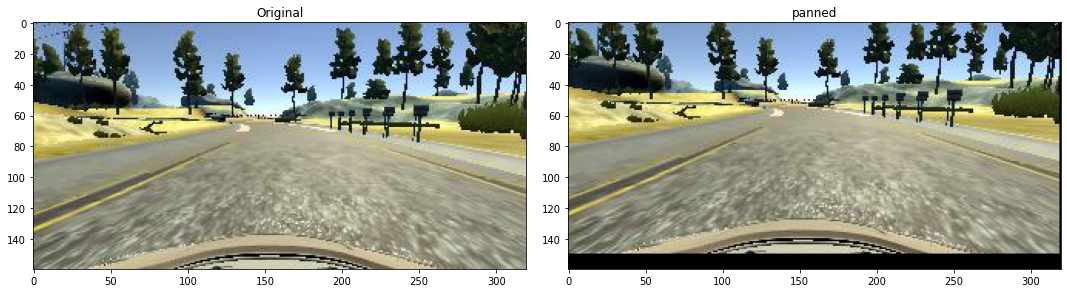

In [ ]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
panned_image=pan(original_image)
fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title("Original")

axes[1].imshow(panned_image)
axes[1].set_title("panned")


In [ ]:
def img_random_brightness(image):
  brightness=iaa.Multiply((0.2,1.2))
  image=brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'brightness altered')

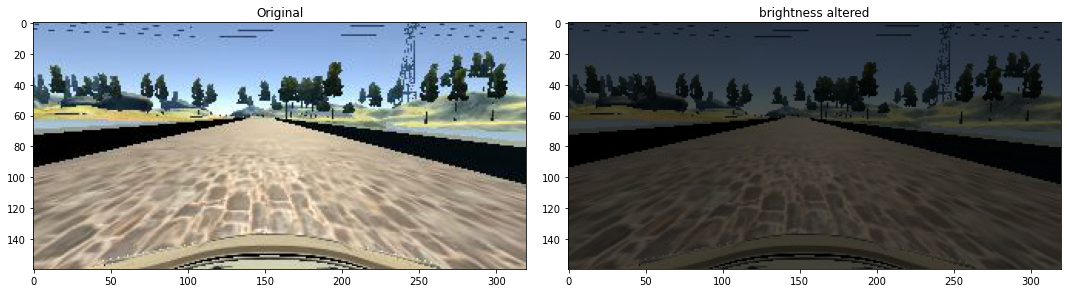

In [ ]:
image=image_paths[random.randint(0,1000)]
original_image=mpimg.imread(image)
alt_bright_image=img_random_brightness(original_image)
fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
axes[0].set_title("Original")

axes[1].imshow(alt_bright_image)
axes[1].set_title("brightness altered")


In [ ]:
def img_random_flip(image,steering_angle):
  image=cv2.flip(image,1)
  steering_angle=-1*steering_angle
  return image,steering_angle

0.09668615=original
-0.09668615= flipped angle


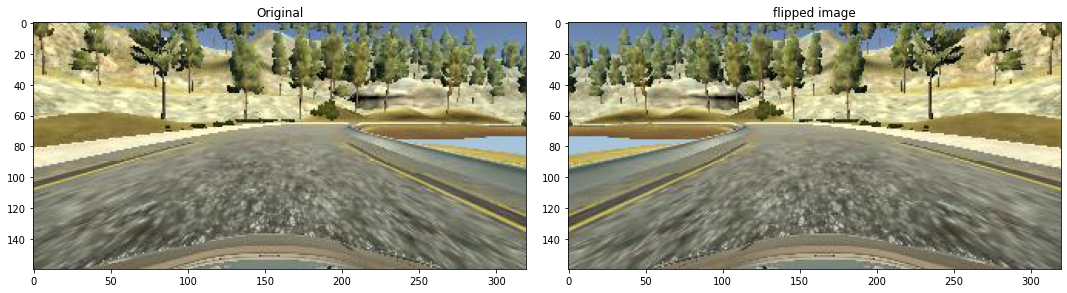

In [ ]:
random_index=random.randint(0,1000)
image=image_paths[random_index]
steering_angle=steerings[random_index]

original_image=mpimg.imread(image)
flipped_image,steering_angle_flip=img_random_flip(original_image,steering_angle)

fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(original_image)
print(f'{steering_angle}=original')
axes[0].set_title("Original")

axes[1].imshow(flipped_image)
axes[1].set_title("flipped image")
print(f'{steering_angle_flip}= flipped angle')

In [ ]:
def random_augment(image,steering_angle):
  image=mpimg.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()<0.5:
    image=img_random_brightness(image)
  if np.random.rand()<0.5:
    image,steering_angle=img_random_flip(image,steering_angle) 
  return image,steering_angle

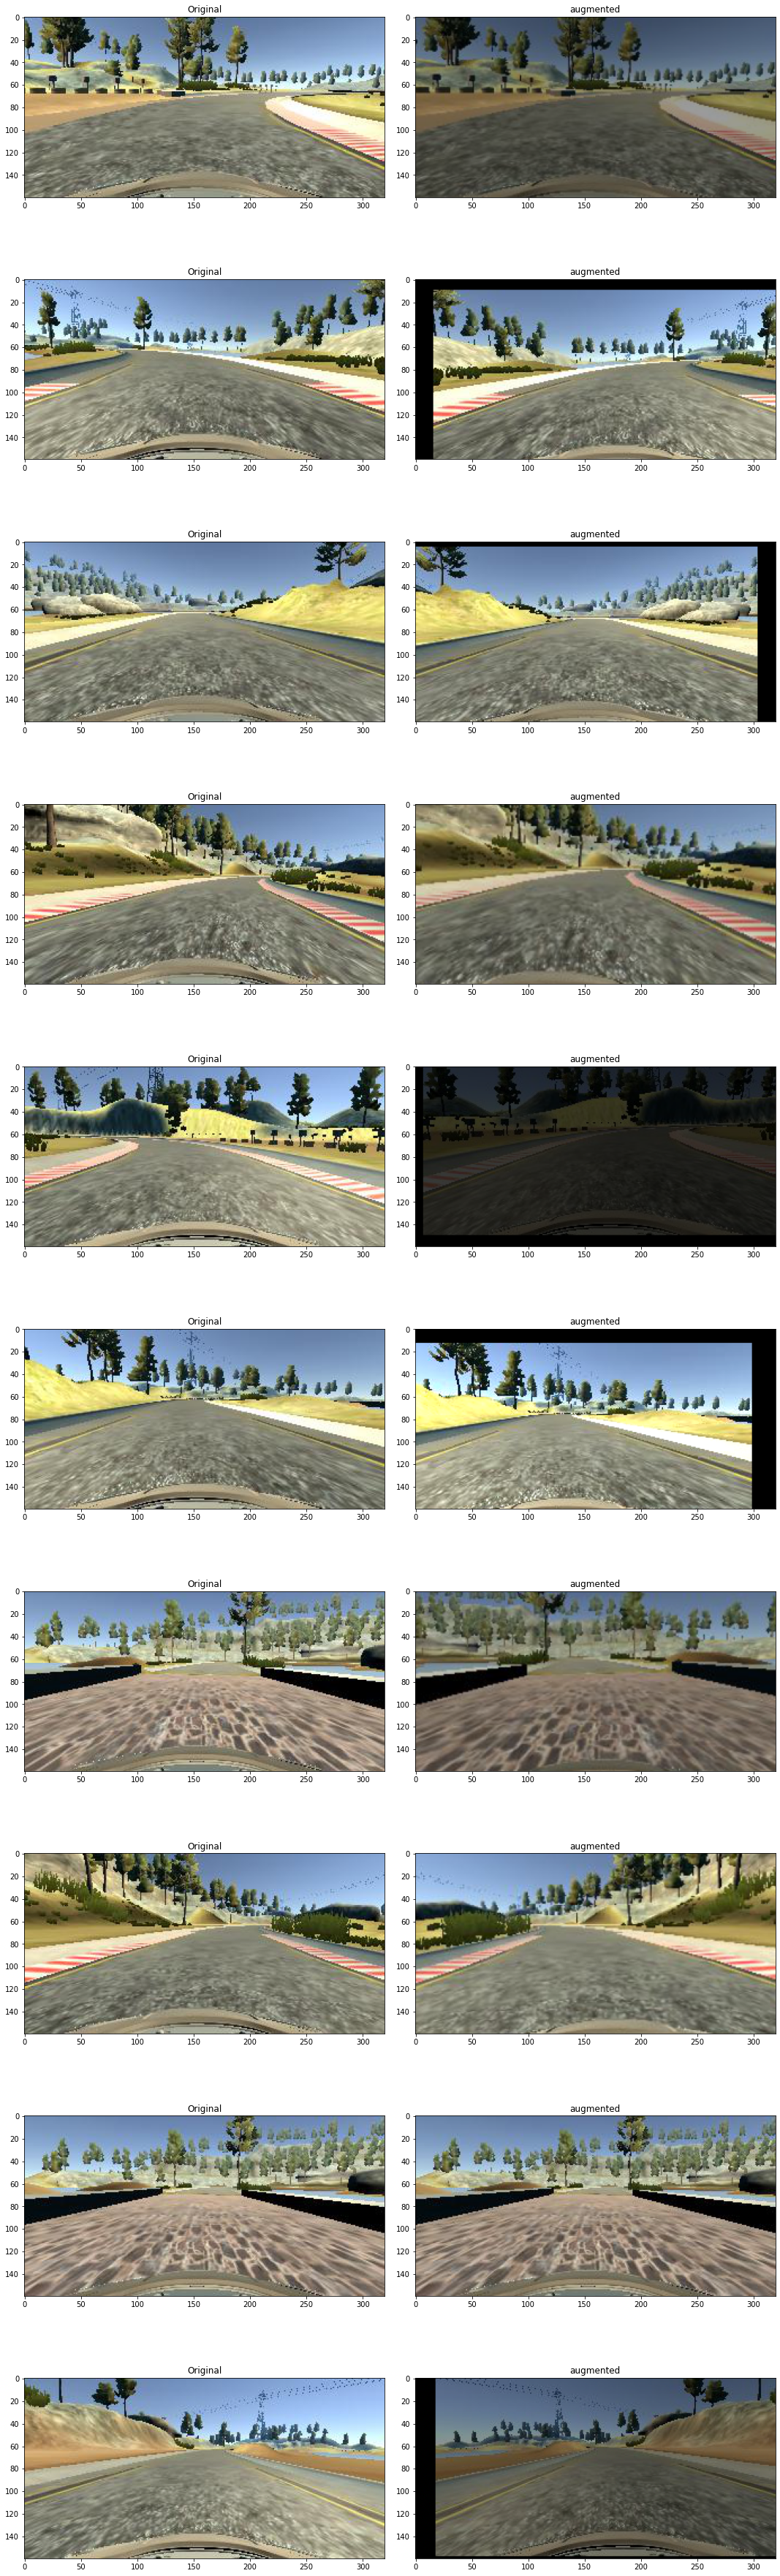

In [ ]:
ncol=2
nrow=10
fig,axes=plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum=random.randint(0,len(image_paths)-1)
  random_image=image_paths[randnum]
  random_steering=steerings[randnum]

  original_image=mpimg.imread(random_image)
  augmented_image,steering=random_augment(random_image,random_steering)

  axes[i][0].imshow(original_image)
  #print(f'{steering_angle}=original')
  axes[i][0].set_title("Original")

  axes[i][1].imshow(augmented_image)
  axes[i][1].set_title("augmented")
  #print(f'{steering_angle_flip}= augmented')

In [ ]:
#pre_processing Images
def img_preprocess(img):
  #img=mpimg.imread(img)
  #removing unneccessary details
  img=img[60:135,:,:]
  #changing the color mode
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  #applying Gaussian blurr-remove noise by applying a convulution kernel
  img=cv2.GaussianBlur(img,(3,3),0)
  #input_size is similar to input of nvidia nn architechture input
  img=cv2.resize(img,(200,66))
  #normalization
  img=img/255
  return img

In [ ]:
# image=image_paths[100]
# original_image=mpimg.imread(image)
# preprocessed_image=img_preprocess(image)
# fig,axes=plt.subplots(1,2,figsize=(15,10))
# fig.tight_layout()
# axes[0].imshow(original_image)
# axes[0].set_title('Orginial Image')
# axes[1].imshow(preprocessed_image)
# axes[1].set_title('Preprocessing Image')

In [ ]:
def batch_generator(image_paths,steering_ang,batch_size,istraining):
  while True:
    batch_img=[]
    batch_steering=[]
    

    for i in range(batch_size):
      random_index=random.randint(0,len(image_paths)-1)

      if istraining:
        im,steering=random_augment(image_paths[random_index],steering_ang[random_index])
      else:
        im=mpimg.imread(image_paths[random_index])
        steering=steering_ang[random_index]
      im=img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    yield (np.asarray(batch_img),np.asarray(batch_steering))

Text(0.5, 1.0, 'validation')

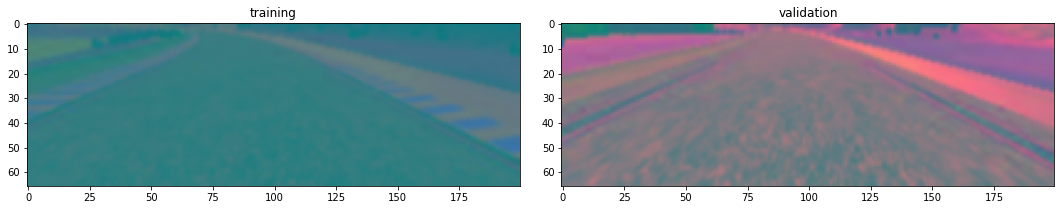

In [ ]:
x_train_gen,y_train_gen=next(batch_generator(X_train,y_train,1,1))
x_valid_gen,y_valid_gen=next(batch_generator(X_valid,y_valid,1,0))

fig,axes=plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()

axes[0].imshow(x_train_gen[0])
axes[0].set_title("training")

axes[1].imshow(x_valid_gen[0])
axes[1].set_title("validation")

In [ ]:
#X_train=np.array(list(map(img_preprocess,X_train)))
#X_valid=np.array(list(map(img_preprocess,X_valid)))

In [ ]:
# plt.imshow(X_train[random.randint(0,len(X_train)-1)])
# plt.axis('off')
# print(X_train.shape)

In [ ]:
#creating nvidida model architecture
def nvidia_model():
  model=Sequential()#its a sequential layer
  model.add(Convolution2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation="elu"))
  model.add(Convolution2D(64,(3,3),activation="elu"))
  model.add(Convolution2D(64,(3,3),activation="elu"))
 # model.add(Dropout(0.5))#for stopping overfitting randomly makes half input=0



  model.add(Flatten())

  model.add(Dense(100,activation='elu'))
 # model.add(Dropout(0.5))

  model.add(Dense(50,activation='elu'))
 # model.add(Dropout(0.5))

  model.add(Dense(10,activation='elu'))
 # model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer=Adam(learning_rate=1e-3)
  model.compile(loss='mse',optimizer=optimizer)
  return model


In [ ]:
model=nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)              

In [ ]:
history=model.fit_generator(batch_generator(X_train,y_train,100,1),
                            steps_per_epoch=300,epochs=10,validation_data=batch_generator(X_valid,y_valid,100,0),validation_steps=200,verbose=1,shuffle=1)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
300/300 [==============================] - 435s 1s/step - loss: 0.2111 - val_loss: 0.0836
Epoch 2/10
300/300 [==============================] - 432s 1s/step - loss: 0.0729 - val_loss: 0.0661
Epoch 3/10
300/300 [==============================] - 436s 1s/step - loss: 0.0649 - val_loss: 0.0537
Epoch 4/10
300/300 [==============================] - 436s 1s/step - loss: 0.0520 - val_loss: 0.0445
Epoch 5/10
300/300 [==============================] - 434s 1s/step - loss: 0.0442 - val_loss: 0.0363
Epoch 6/10
300/300 [==============================] - 433s 1s/step - loss: 0.0427 - val_loss: 0.0287
Epoch 7/10
300/300 [==============================] - 427s 1s/step - loss: 0.0371 - val_loss: 0.0289
Epoch 8/10
300/300 [==============================] - 424s 1s/step - loss: 0.0353 - val_loss: 0.0261
Epoch 9/10
300/300 [==============================] - 428s 1s/step - loss: 0.0330 - val_loss: 0.0277
Epoch 10/10
300/300 [==============================] - 427s 1s/step - loss: 0.0316 - val_lo

Text(0.5, 0, 'Epoch')

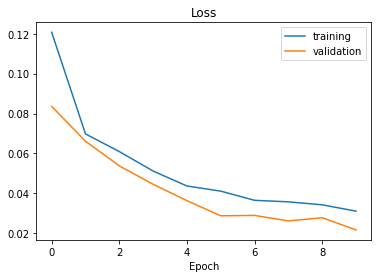

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save('model.h5')
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>